## Inflation Forecasting with FRED Data

The following code attempts to offer tools for forecasting inflation given a set of macro economic input data from FRED.  Data from FRED was selected based on its proximity (known correlation) to inflation.

In [14]:
# standard imports
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline



from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns

In [ ]:
!pip install yfinance
!pip install quandl

In [3]:
import yfinance as yf
import quandl

In [8]:
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [4]:
quandl.ApiConfig.api_key = "dFWX9cPgKNkz_shZZ2x3"

In [5]:
# Data collection from Quandl
# Commercial and Industrial Loans
candiloans= quandl.get("FRED/TOTCI", start_date='2000-07-01', end_date = '2021-07-01', collapse = 'monthly')
candiloans.rename(columns={ "Value" : "CandILoans"}, inplace = True)
# Unemployment Rate
unrate= quandl.get("FRED/UNRATE", start_date='2000-07-01', end_date = '2021-07-01', collapse = 'monthly')
unrate.rename(columns={ "Value" : "UnemplRate"}, inplace = True)
# Housing Starts
houstart= quandl.get("FRED/HOUST", start_date='2000-07-01', end_date = '2021-07-01', collapse = 'monthly')
houstart.rename(columns={ "Value" : "HOUST"}, inplace = True)
# Industrial Production
indpro = quandl.get("FRED/INDPRO", start_date='2000-07-01', end_date = '2021-07-01', collapse = 'monthly')
indpro.rename(columns={ "Value" : "INDPRO"}, inplace = True)
# Personal Savings Rate
psave_rt = quandl.get("FRED/PSAVERT", start_date='2000-07-01', end_date = '2021-07-01', collapse = 'monthly')
psave_rt.rename(columns={ "Value" : "PSAVERT"}, inplace = True)
# CPI for All Urban Consumers
CPI = quandl.get("FRED/CPIAUCSL", start_date='2000-07-01', end_date = '2021-07-01', collapse = 'monthly')
CPI.rename(columns={ "Value" : "CPI_All"}, inplace = True)
# Ten Year Treasury
Ten_YR = quandl.get("FRED/DGS10", start_date='2000-07-01', end_date = '2021-07-01', collapse = 'monthly')
Ten_YR.rename(columns={ "Value" : "10YR"}, inplace = True)
# Aggregate data into single dataframe
fred_data = pd.concat([candiloans, unrate, houstart, indpro, psave_rt, Ten_YR, CPI], axis=1, join= 'inner')

In [6]:
# Check data
fred_data.tail()

,CandILoans,UnemplRate,HOUST,INDPRO,PSAVERT,10YR,CPI_All
Date,,,,,,,
2021-01-31,2565.4135,6.3,1625.0,99.4076,20.7,1.11,262.231
2021-02-28,2600.9517,6.2,1447.0,96.3720,14.8,1.44,263.161
2021-03-31,2564.9343,6.0,1725.0,98.9400,27.6,1.74,264.793
2021-04-30,2560.2289,6.1,1514.0,98.9660,14.5,1.65,266.832
2021-05-31,2546.5231,5.8,1546.0,99.6536,12.4,1.58,268.551


In [9]:
# For regression models, data needs to be lagged.
# Set the lag period for lagging the data
return_period = 3
# Reframe data into supervised regression-based framework 

Y = np.log(fred_data.loc[:, ('CPI_All')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X = np.log(fred_data.loc[:, ('CandILoans', 'UnemplRate', 'HOUST', 'INDPRO', 'PSAVERT', '10YR')]).diff(return_period)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

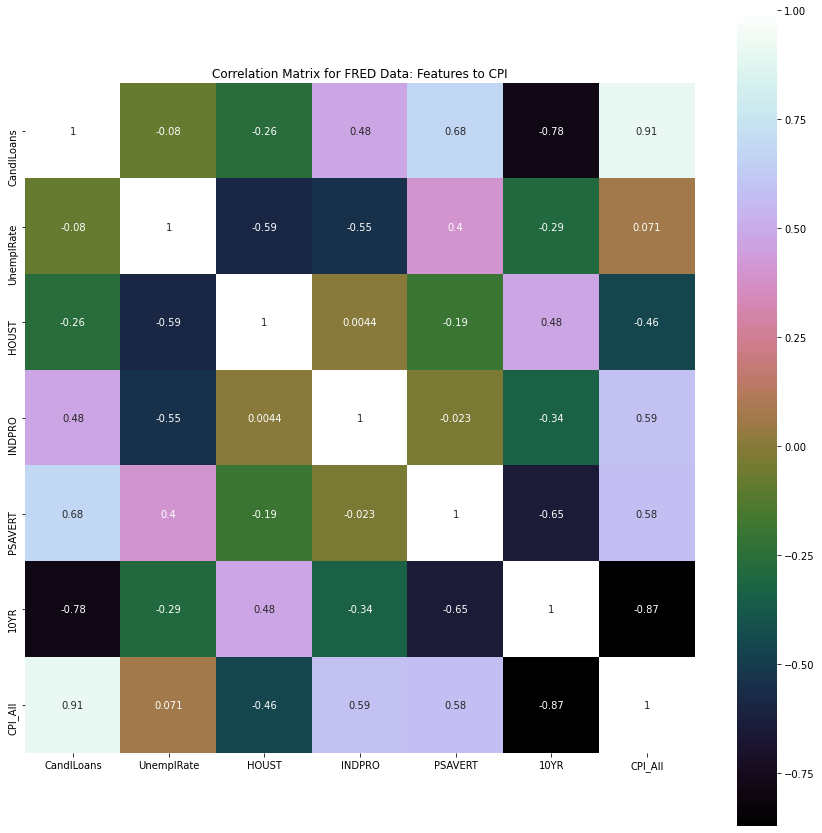

In [16]:
# Produces a correlation matrix for examining relationship between dependent and independent variables
correlation = fred_data.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix for FRED Data: Features to CPI')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# Correlation Matrix Results
We see a very strong correlation between CPI and Commercial and Industrial Loans (This may be worth exploring separately) (.91).

In [17]:
## How does Sklearn rate the features in the data?
# Sklearn to find feature importance 
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
INDPRO,0.828223
HOUST,0.098586
PSAVERT,0.063507
CandILoans,0.043115
UnemplRate,0.003327
10YR,0.002698


In [19]:
# Split data into training and test sets
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

# Model selection
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [20]:
# Model selection
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [21]:
# Loop over the models 
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000050 (0.000051) 0.000039 0.000186
LASSO: 0.000043 (0.000059) 0.000044 0.000033
EN: 0.000043 (0.000059) 0.000044 0.000033
KNN: 0.000058 (0.000062) 0.000034 0.000042
CART: 0.000078 (0.000072) 0.000000 0.000035
SVR: 0.000068 (0.000053) 0.000072 0.000062
MLP: 0.000782 (0.000615) 0.000125 0.005439
ABR: 0.000056 (0.000063) 0.000010 0.000098
GBR: 0.000063 (0.000054) 0.000001 0.000047
RFR: 0.000054 (0.000053) 0.000008 0.000070
ETR: 0.000056 (0.000056) 0.000000 0.000072


It appears that LASSO and Elastic Net models perform the best when looking at the test results (last value).

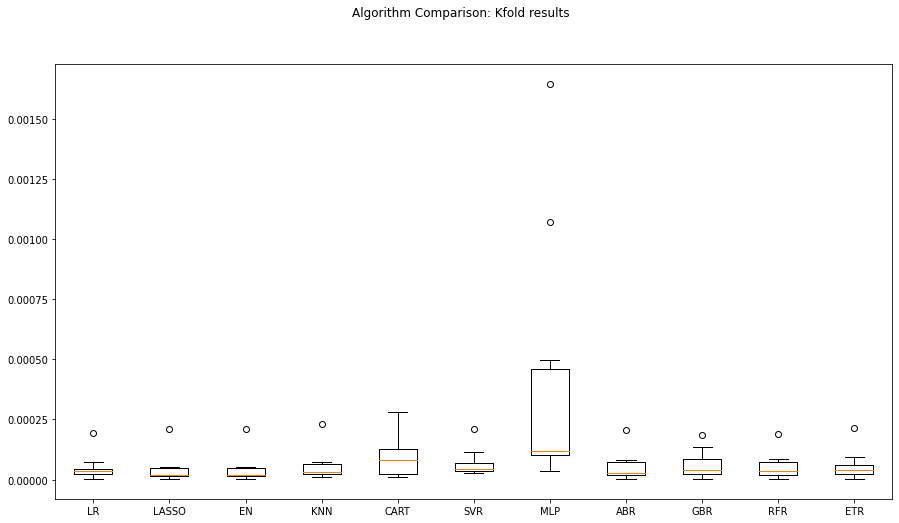

In [30]:
# K fold results
# Better performing models have a stonger relationship between dependent and independent variable
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

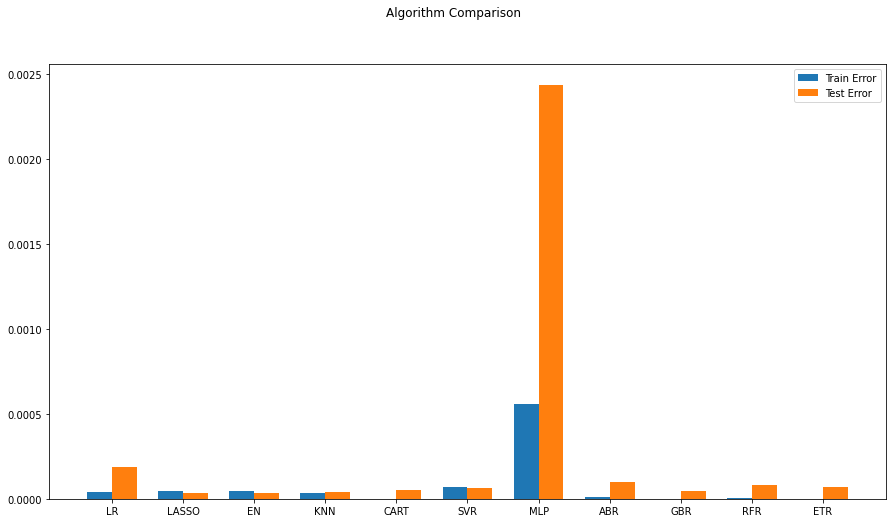

In [31]:
# Training and test error
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [22]:
# Elastic Net 
model_elast = ElasticNet(alpha=1.0, l1_ratio=0.5)
model_elast.fit(X_train, Y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
elast_pred = model_elast.predict(X_test)
elast_results = pd.DataFrame({"Predictions": elast_pred, "Actual": Y_test})

Text(0.5, 1.0, 'Elastic Net Performance')

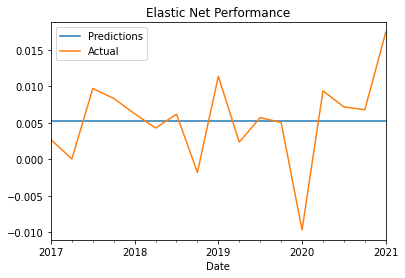

In [27]:
elast_results.plot()
plt.title('Elastic Net Performance')

In [29]:
# KNN
model_knn = KNeighborsRegressor()
model_knn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [30]:
knn_pred = model_knn.predict(X_test)
knn_results = pd.DataFrame({"Predictions": knn_pred, "Actual": Y_test})

Text(0.5, 1.0, 'KNN Performance')

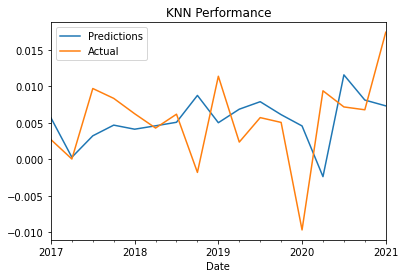

In [31]:
knn_results.plot()
plt.title('KNN Performance')

In [32]:
# Model tuning for GBR
modelGBR= GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2)
modelGBR.fit(X_train, Y_train)



GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=2, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
GBR_pred = modelGBR.predict(X_test)
GBR_results = pd.DataFrame({"Predictions": GBR_pred, "Actual": Y_test})


In [34]:
# Used for looking at next few periods (Future)
future = np.log(fred_data.tail(1))
future.drop(['CPI_All'], axis = 1, inplace=True)


Text(0.5, 1.0, 'GBR Performance')

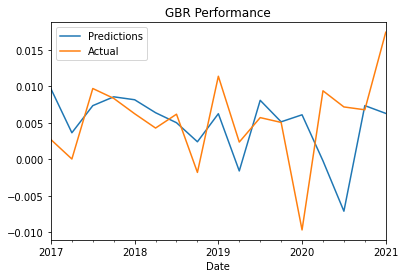

In [36]:
GBR_results.plot()
plt.title('GBR Performance')

# **GBR Results **
It appears there is a divergence with what the model is prediction at tail end of the dataset.  

## LSTM Model

In [37]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [ ]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

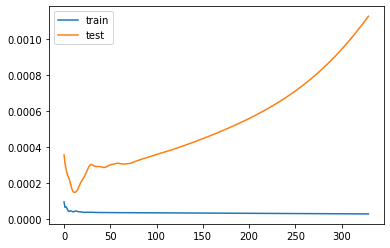

In [39]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [40]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
lstm_pred = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,lstm_pred)

In [41]:
lstm_results = pd.DataFrame({"Predictions": lstm_pred.ravel(), "Actual": Y_test})

Text(0.5, 1.0, 'LSTM Performance')

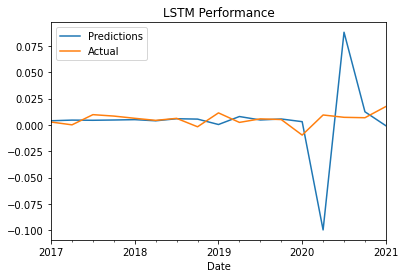

In [42]:
lstm_results.plot()
plt.title('LSTM Performance')

# Commodities with CPI
The following section evaluates the feasablity of using commodity data to forecast CPI.  It follows the same approach as above. 

In [43]:
#Download commodity data from Yahoo Finance, (Copper, Silver, Gold, Lumber, Crude Oil, Coffee, Corn, Wheat (in order)  )
symbols = ['HG=F','SI=F', 'GC=F', 'LBS=F', 'CL=F', 'KC=F', 'ZC=F', 'ZW=F']
start = '2001-01-01'
end = '2021-07-10'

df = pd.DataFrame()
for s in symbols:
    df[s] = yf.download(s,start,end)['Adj Close']

# Resample for monthly to match FRED data
df = df.resample('M').mean()

# CPI for All Urban Consumers
CPIwComm = quandl.get("FRED/CPIAUCSL", start_date='2001-01-01', end_date = '2021-07-01', collapse = 'monthly')
CPIwComm.rename(columns={ "Value" : "CPI_All"}, inplace = True)

#Combine dataframes
comm_df = pd.concat([df, CPIwComm], axis=1, join= 'inner')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [44]:
# Reframe data into supervised regression-based framework 

Y_comm = np.log(comm_df.loc[:, ('CPI_All')]).diff(return_period).shift(-return_period)
Y_comm.name = Y_comm.name[-1]+'_pred'

X_comm = np.log(comm_df.loc[:, ('HG=F',	'SI=F',	'GC=F',	'LBS=F',	'CL=F',	'KC=F',	'ZC=F',	'ZW=F')]).diff(return_period)

dataset = pd.concat([Y_comm, X_comm], axis=1).dropna().iloc[::return_period, :]
Y_comm = dataset.loc[:, Y_comm.name]
X_comm = dataset.loc[:, X_comm.columns]

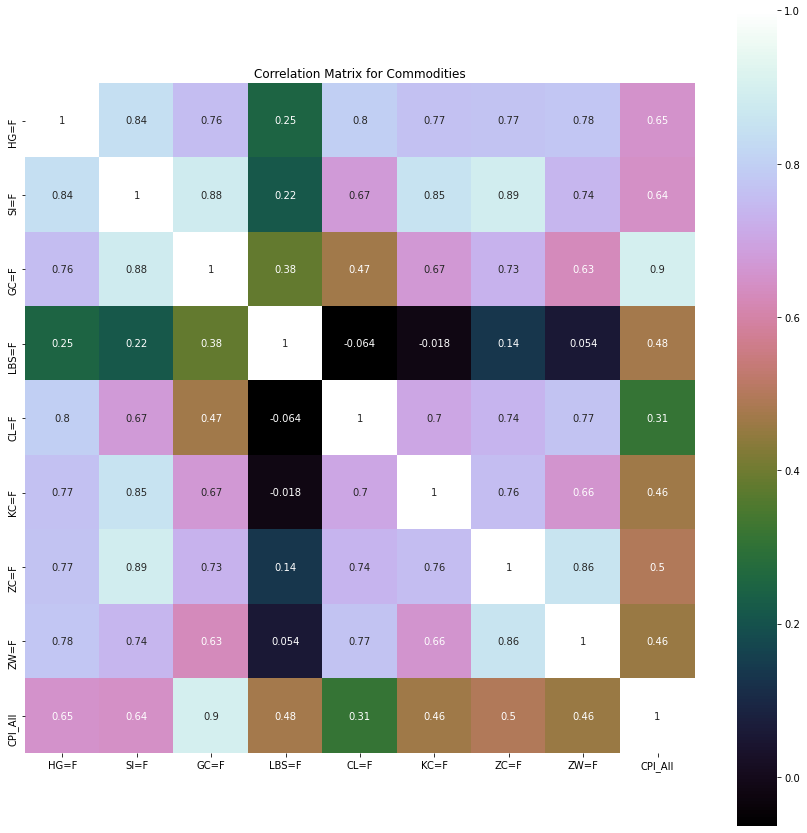

In [45]:
# Produces a correlation matrix for examining relationship between dependent and independent variables
correlation_comm = comm_df.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix for Commodities')
sns.heatmap(correlation_comm, vmax=1, square=True,annot=True,cmap='cubehelix')

Strong correlation with Gold (GC=F), moderate with copper and silver show in the matrix above.

In [46]:
# Sklearn to find feature importance 
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X_comm,Y_comm)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_comm.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
ZC=F,19.444036
SI=F,12.571267
ZW=F,11.216751
HG=F,11.120797
GC=F,4.123571
CL=F,2.202633
KC=F,2.097474
LBS=F,2.089537


In [47]:
# Split data into training and test sets
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train_comm, X_test_comm, Y_train_comm, Y_test_comm = train_test_split(X_comm, Y_comm, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X_comm) * (1-validation_size))
X_train_comm, X_test_comm = X_comm[0:train_size], X_comm[train_size:len(X_comm)]
Y_train_comm, Y_test_comm = Y_comm[0:train_size], Y_comm[train_size:len(X)]

In [48]:
# Loop over the models 
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train_comm, Y_train_comm, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train_comm, Y_train_comm)
    train_result = mean_squared_error(res.predict(X_train_comm), Y_train_comm)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test_comm), Y_test_comm)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000045 (0.000039) 0.000029 0.000044
LASSO: 0.000047 (0.000066) 0.000044 0.000034
EN: 0.000047 (0.000066) 0.000044 0.000034
KNN: 0.000049 (0.000057) 0.000031 0.000044
CART: 0.000088 (0.000063) 0.000000 0.000044
SVR: 0.000071 (0.000060) 0.000071 0.000066
MLP: 0.001433 (0.001036) 0.001045 0.000780
ABR: 0.000051 (0.000055) 0.000008 0.000032
GBR: 0.000065 (0.000056) 0.000000 0.000032
RFR: 0.000047 (0.000046) 0.000007 0.000036
ETR: 0.000049 (0.000055) 0.000000 0.000034


In [49]:
# GBR with commodity data
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2)
gbr.fit(X_train_comm, Y_train_comm)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=2, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Text(0.5, 1.0, 'GBR with Commodity Data')

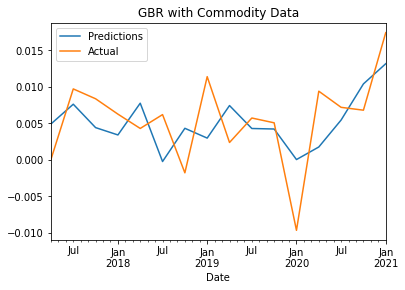

In [51]:
GBR_pred = gbr.predict(X_test_comm)
GBR_results = pd.DataFrame({"Predictions": GBR_pred, "Actual": Y_test_comm})
GBR_results.plot()
plt.title('GBR with Commodity Data')

GBR with the commodity data appears to produce a model that seems to have decent performance.  